In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [5]:
data_dir = '/content/drive/MyDrive/PlantDisease/Data'
categories = os.listdir(data_dir)

# Load images and Labels
images = []
labels = []

for category in categories:
    print(category)
    folder_path = os.path.join(data_dir, category)
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (64, 64)) #Resize to uniform size
            images.append(img)
            labels.append(category)

# Convert images and labels to numpy arrays
images = np.array(images)

Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Tomato_mosaic_virus
Tomato___Target_Spot
Tomato___Late_blight
Tomato___Early_blight
Tomato___healthy
Tomato___Bacterial_spot


In [6]:
#convert to numpy arrays
x = np.array(images)
y = np.array(labels)

print("Labels: ",np.unique(y))
print("Data Shape: ",x.shape)

Labels:  ['Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Target_Spot' 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
 'Tomato___Tomato_mosaic_virus' 'Tomato___healthy']
Data Shape:  (13070, 64, 64, 3)


Class Distribution
Tomato___Tomato_Yellow_Leaf_Curl_Virus    1971
Tomato___healthy                          1955
Tomato___Early_blight                     1940
Tomato___Late_blight                      1851
Tomato___Target_Spot                      1827
Tomato___Tomato_mosaic_virus              1800
Tomato___Bacterial_spot                   1726
Name: count, dtype: int64


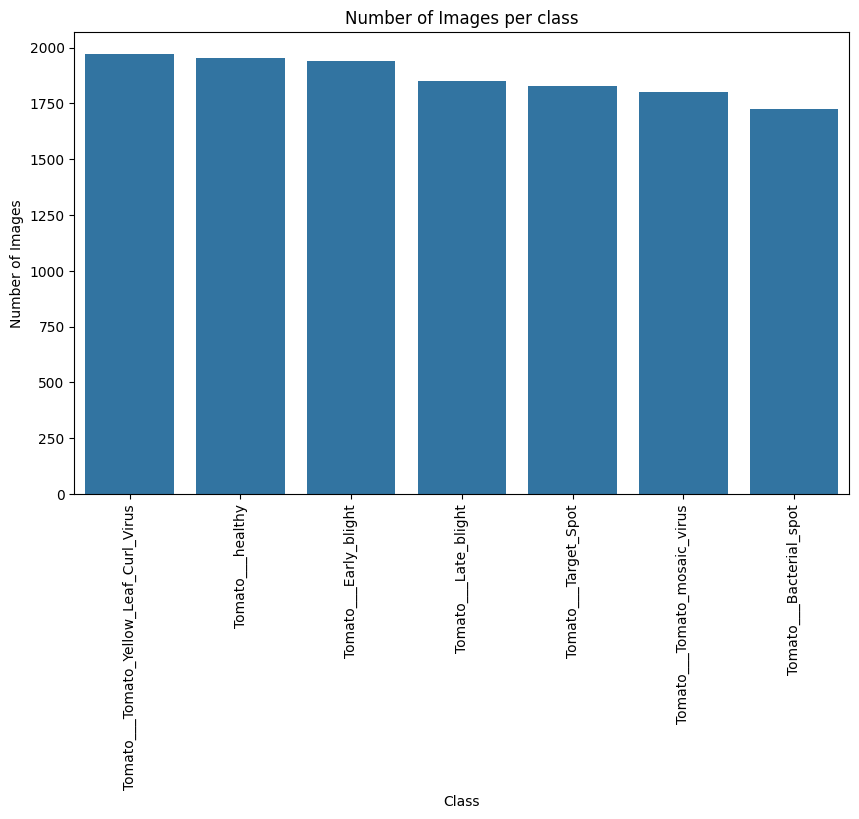

In [8]:
class_counts = pd.Series(y).value_counts()
print("Class Distribution")
print(class_counts)

#plot class distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x = class_counts.index, y = class_counts.values)
plt.xticks(rotation = 90)
plt.title("Number of Images per class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [9]:
#remove corrupted images()
valid_images = []
valid_labels= []

for img, label in zip(x, y):
  if img.shape == (64, 64, 3):
    valid_images.append(img)
    valid_labels.append(label)

x = np.array(valid_images)
y = np.array(valid_labels)

print("Cleaned Data Shape: ", x.shape)

Cleaned Data Shape:  (13070, 64, 64, 3)


In [10]:
#Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#save class names for later use
class_names = le.classes_
class_names

array(['Tomato___Bacterial_spot', 'Tomato___Early_blight',
       'Tomato___Late_blight', 'Tomato___Target_Spot',
       'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
       'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'], dtype='<U38')

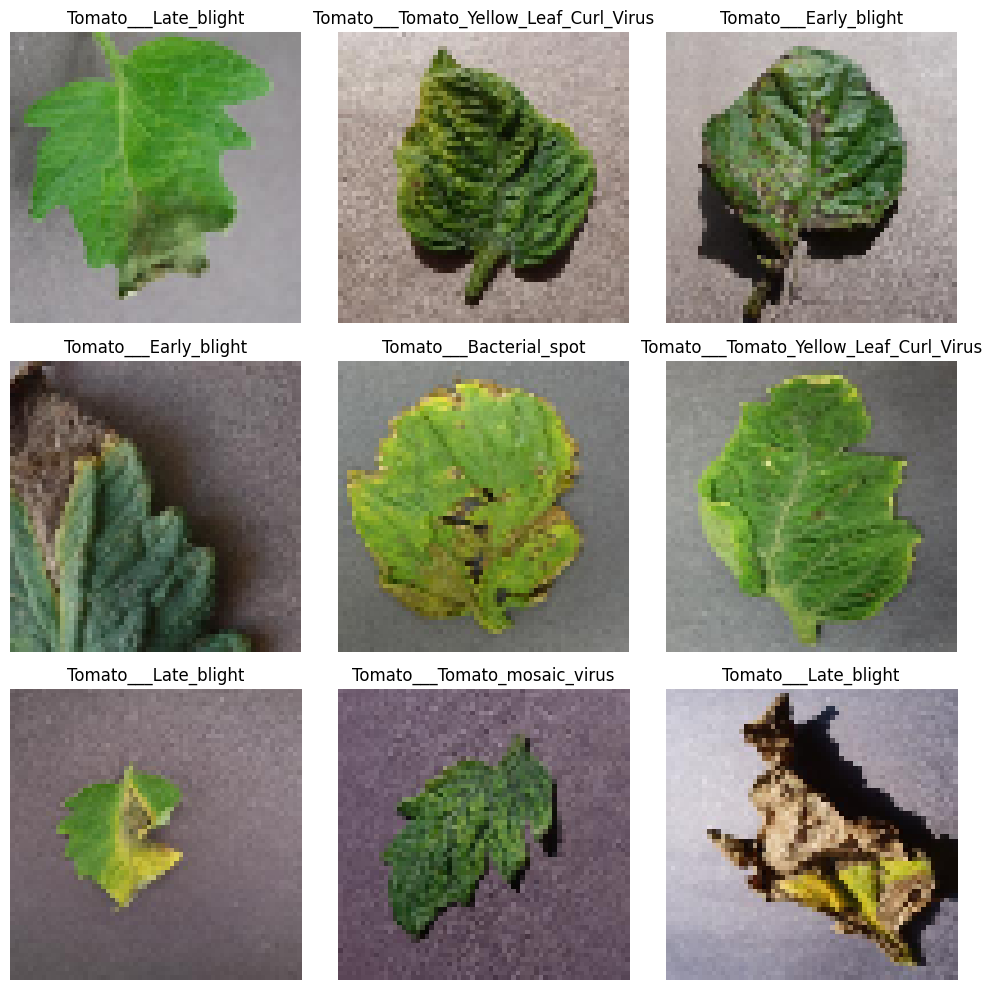

In [13]:
import random

plt.figure(figsize=(10,10))
for i in range(9):
  idx = random.randint(0, len(x))
  plt.subplot(3, 3, i+1)
  plt.imshow(cv2.cvtColor(x[idx], cv2.COLOR_BGR2RGB))
  plt.title(class_names[y_encoded[idx]])
  plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
def extract_color_histogram(image, bins=(8, 8, 8)):

    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

hist_features = [extract_color_histogram(img) for img in x]
x_features = np.array(hist_features)

In [21]:
x_features.shape

(13070, 512)

In [15]:
#Choose model
model = SVC(kernel='rbf', C=10, gamma='scale')

In [16]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(x_features, y_encoded, test_size=0.2, random_state=42)

#train model
model.fit(X_train, y_train)

#predict
y_pred=model.predict(X_test)

Accuracy: 0.9755164498852333
F1 Score: 0.9754448634847048


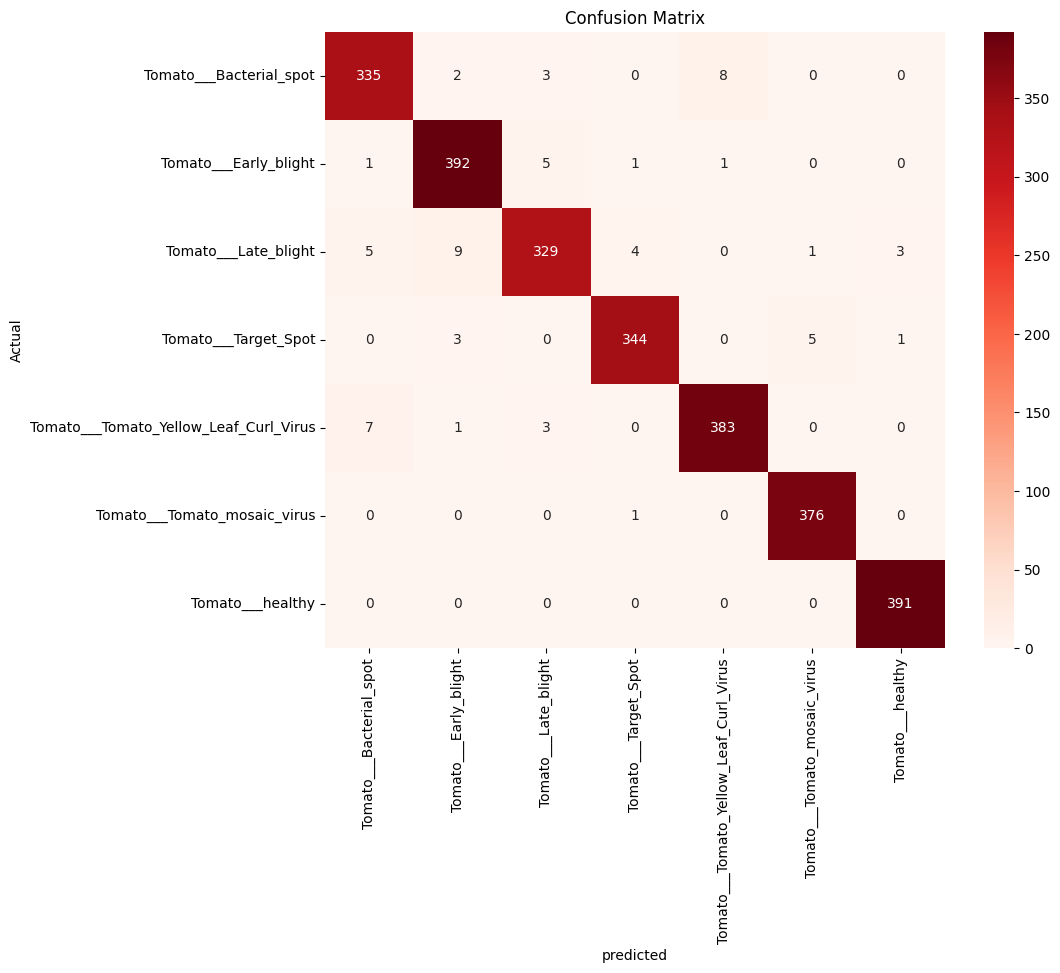

In [17]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,classification_report

#Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

#F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

#confusion Matrix
cm = confusion_matrix(y_test, y_pred)

#plot confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [18]:
#classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Classification Report:
                                        precision    recall  f1-score   support

               Tomato___Bacterial_spot       0.96      0.96      0.96       348
                 Tomato___Early_blight       0.96      0.98      0.97       400
                  Tomato___Late_blight       0.97      0.94      0.95       351
                  Tomato___Target_Spot       0.98      0.97      0.98       353
Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.98      0.97      0.97       394
          Tomato___Tomato_mosaic_virus       0.98      1.00      0.99       377
                      Tomato___healthy       0.99      1.00      0.99       391

                              accuracy                           0.98      2614
                             macro avg       0.98      0.97      0.98      2614
                          weighted avg       0.98      0.98      0.98      2614

